In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from IndustryMap2 import industry_categories

In [36]:
df = pd.read_csv('../SavedData/dataset2_cleaned.csv')
#df['Datetime'] = pd.to_datetime(df['Datetime'])

# Remove capitalization and spaces from 'Third Party Name' column
#df['Third Party Name'] = df['Third Party Name'].str.lower().str.replace(' ', '')

In [37]:
training_transactions = pd.read_csv('../SavedData/dataset2_training_transaction.csv')
testing_transactions = pd.read_csv('../SavedData/dataset2_testing_transaction.csv')

training_transactions['Datetime'] = pd.to_datetime(training_transactions['Datetime'])
testing_transactions['Datetime'] = pd.to_datetime(testing_transactions['Datetime'])

training_transactions['Third Party Name'] = training_transactions['Third Party Name'].str.lower().str.replace(' ', '')
testing_transactions['Third Party Name'] = testing_transactions['Third Party Name'].str.lower().str.replace(' ', '')

In [38]:
testing_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
0,14/03/2023,18:33:00,712474734.0,-1324.548831,-31.23,NaN,deliveroo,2023-03-14 18:33:00
1,14/03/2023,17:28:00,419550103.0,6544.593463,-125.30,NaN,looselyfitted,2023-03-14 17:28:00
2,31/08/2023,23:59:00,834581602.0,925.931550,-7.00,NaN,xbox,2023-08-31 23:59:00
3,31/10/2023,09:27:00,250957494.0,1090.427100,-37.99,NaN,sportsdirect,2023-10-31 09:27:00
4,05/03/2023,16:34:00,675231808.0,4038.532728,-158.90,NaN,selfridges,2023-03-05 16:34:00
...,...,...,...,...,...,...,...,...
45834,31/07/2023,23:59:00,117308635.0,1863.971883,-14.99,NaN,blizzard,2023-07-31 23:59:00
45835,02/02/2023,14:46:00,299871610.0,-1106.116847,-55.29,NaN,topshop,2023-02-02 14:46:00
45836,11/01/2023,19:39:00,656812046.0,2980.102487,-118.16,NaN,tesco,2023-01-11 19:39:00
45837,31/05/2023,23:59:00,690941877.0,225.584962,-15.99,NaN,netflix,2023-05-31 23:59:00


In [39]:
#training_transactions, testing_transactions = train_test_split(df, test_size=0.2, random_state=2)

## Remove certain industries

In [40]:
# Find all keys in the dictionary where the value is 'subscription' or 'finance'
companies_to_remove = [company for company, category in industry_categories.items()
                       if category in ['subscription', 'finance']]
companies_to_remove.append('grandunionbjj')
training_transactions = training_transactions[~((training_transactions['Third Party Name'] == 'amazon') & (training_transactions['Amount'] == -7.99))]
testing_transactions = testing_transactions[~((testing_transactions['Third Party Name'] == 'amazon') & (testing_transactions['Amount'] == -7.99))]

training_transactions = training_transactions[~training_transactions['Third Party Name'].isin(companies_to_remove)]
testing_transactions = testing_transactions[~testing_transactions['Third Party Name'].isin(companies_to_remove)]

## Changing Values to Positive Absolute

In [41]:
training_payments_df = training_transactions[training_transactions['Amount'] > 0].copy()
training_expenditures_df = training_transactions[training_transactions['Amount'] < 0].copy()
training_expenditures_df["Amount"] = training_expenditures_df["Amount"].abs()

testing_payments_df = testing_transactions[testing_transactions['Amount'] > 0].copy()
testing_expenditures_df = testing_transactions[testing_transactions['Amount'] < 0].copy()
testing_expenditures_df["Amount"] = testing_expenditures_df["Amount"].abs()

In [42]:
training_expenditures_df = training_expenditures_df.copy()
testing_expenditures_df = testing_expenditures_df.copy()

training_expenditures_df['DayOfWeek'] = training_expenditures_df['Datetime'].dt.dayofweek
training_expenditures_df['DayOfMonth'] = training_expenditures_df['Datetime'].dt.day
training_expenditures_df['MonthOfYear'] = training_expenditures_df['Datetime'].dt.month

testing_expenditures_df['DayOfWeek'] = testing_expenditures_df['Datetime'].dt.dayofweek
testing_expenditures_df['DayOfMonth'] = testing_expenditures_df['Datetime'].dt.day
testing_expenditures_df['MonthOfYear'] = testing_expenditures_df['Datetime'].dt.month

In [43]:
training_expenditures_df = training_expenditures_df.copy()
testing_expenditures_df = testing_expenditures_df.copy()

training_expenditures_df['Hour'] = training_expenditures_df['Datetime'].dt.hour
testing_expenditures_df['Hour'] = testing_expenditures_df['Datetime'].dt.hour

In [44]:
patterns_train = training_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Third Party Name'])['Amount'].sum().reset_index()
patterns_test = testing_expenditures_df.groupby(['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Third Party Name'])['Amount'].sum().reset_index()

In [45]:
patterns_train

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Name,Amount
0,101531259.0,8,0,18,9,tesco,129.71
1,101531259.0,8,0,19,6,tesco,161.08
2,101531259.0,8,1,23,5,tesco,114.21
3,101531259.0,8,2,11,10,tesco,65.20
4,101531259.0,8,2,19,4,tesco,134.46
...,...,...,...,...,...,...,...
129184,999752672.0,20,3,17,8,tesco,38.48
129185,999752672.0,20,3,23,3,tesco,109.98
129186,999752672.0,20,3,27,4,tesco,68.17
129187,999752672.0,20,3,28,9,tesco,146.27


## Building Model Dictionary

In [46]:
account_no = list(df['Account No'].unique())
key_list = account_no
value_list = [0] * len(account_no)
account_num_models = dict(zip(key_list, value_list))

## Training Model Dictionary

In [47]:
for account in account_no:
    X_train = patterns_train[patterns_train['Account No'] == account][['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
    X_test = patterns_test[patterns_test['Account No'] == account][['Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 'Amount']]
    
    if(len(X_test) > 3): 
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        user_model = IsolationForest(n_estimators=100, contamination=0.025)
        account_num_models[account] = user_model.fit(X_train_scaled)

        predictions = account_num_models[account].predict(X_test_scaled)

        # Save predictions to the DataFrame
        patterns_test.loc[X_test.index, 'Prediction'] = predictions
    else:
        patterns_test.loc[X_test.index, 'Prediction'] = 0
    
# Check the DataFrame to see the predictions column
print(patterns_test.head())

    Account No  Hour  DayOfWeek  DayOfMonth  MonthOfYear Third Party Name  \
0  101531259.0     3          4          13            1             head   
1  101531259.0     8          0          10            4            tesco   
2  101531259.0     8          0          27           11            tesco   
3  101531259.0     8          5          12            8            tesco   
4  101531259.0     9          0           8            5            tesco   

   Amount  Prediction  
0  200.00         1.0  
1   76.39         1.0  
2  149.09         1.0  
3   95.92         1.0  
4  125.94         1.0  


## Pruning for Anomalous Transactions

In [48]:
anomaly_tx = patterns_test.copy()

In [49]:
anomaly_tx

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Name,Amount,Prediction
0,101531259.0,3,4,13,1,head,200.00,1.0
1,101531259.0,8,0,10,4,tesco,76.39,1.0
2,101531259.0,8,0,27,11,tesco,149.09,1.0
3,101531259.0,8,5,12,8,tesco,95.92,1.0
4,101531259.0,9,0,8,5,tesco,125.94,1.0
...,...,...,...,...,...,...,...,...
32798,999752672.0,18,4,22,9,tesco,71.38,1.0
32799,999752672.0,19,1,4,4,tesco,122.99,1.0
32800,999752672.0,19,2,8,3,tesco,155.53,1.0
32801,999752672.0,19,3,3,8,tesco,148.89,1.0


In [50]:
# Calculate Q1 and Q3
business_groups = anomaly_tx.groupby('Third Party Name')['Amount']
iqr_dict = {name: {'Q1': group.quantile(0.25), 'Q3': group.quantile(0.75), 'IQR': group.quantile(0.75) - group.quantile(0.25)} 
            for name, group in business_groups}

In [51]:
#Function to categorize the anomaly transactions
def tx_risk_category(row):
    business = row['Third Party Name']
    amount = row['Amount']
    if (business in iqr_dict) and (row['Prediction'] == -1):
        q1 = iqr_dict[business]['Q1']
        q3 = iqr_dict[business]['Q3']
        iqr = iqr_dict[business]['IQR']
        medium_risk = q3
        high_risk = q3 + 1.5 * iqr 
        
        if amount > high_risk:
            return 'High Risk'
        elif amount > medium_risk:
            return 'Medium Risk'
        else:
            return 'Low Risk'
    else:
        return 'No Risk'

anomaly_tx['Risk Category'] = anomaly_tx.apply(tx_risk_category, axis=1)

In [55]:
anomaly_tx[anomaly_tx['Risk Category']== 'Low Risk']

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Name,Amount,Prediction,Risk Category
19,101531259.0,15,6,1,1,matalan,104.00,-1.0,Low Risk
20,101531259.0,16,6,1,1,topshop,99.50,-1.0,Low Risk
21,101531259.0,21,2,8,3,deliveroo,15.00,-1.0,Low Risk
46,105375973.0,12,6,3,12,sportsdirect,66.17,-1.0,Low Risk
190,108563213.0,19,1,31,1,tesco,64.36,-1.0,Low Risk
...,...,...,...,...,...,...,...,...,...
32743,998405607.0,0,0,17,4,justeat,32.95,-1.0,Low Risk
32745,998405607.0,9,2,15,11,tesco,57.08,-1.0,Low Risk
32751,998405607.0,12,6,29,10,tesco,55.56,-1.0,Low Risk
32758,998405607.0,18,1,17,10,tesco,35.07,-1.0,Low Risk


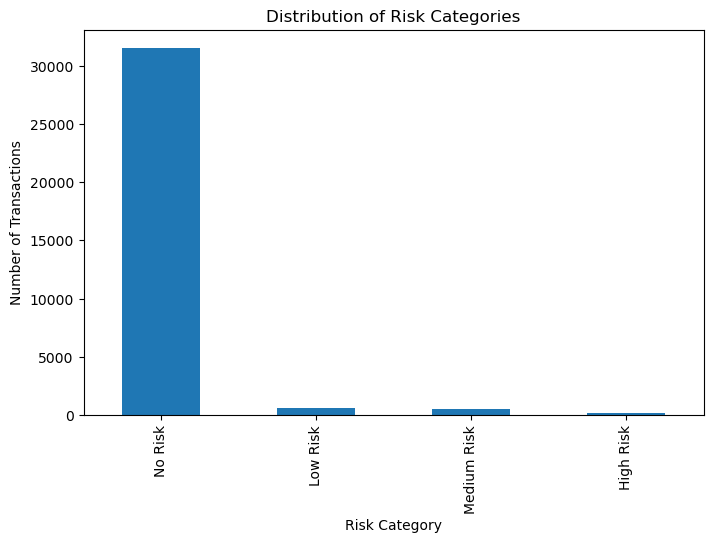

In [56]:
import matplotlib.pyplot as plt

no_of_risk = anomaly_tx['Risk Category'].value_counts()
plt.figure(figsize=(8, 5))
no_of_risk.plot(kind='bar')
plt.title('Distribution of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Number of Transactions')
plt.show()

In [57]:
anomaly_tx.to_csv("Isolation_forest_results.csv", index= False)